# $1^{st}$ exercises

## Notebook setup

#### Libraries

In [11]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from math import pi as pi

from scipy.stats import chi2
from scipy.stats import norm
from scipy.stats import cauchy

#### Functions

In [2]:
#Load and print config files
def LoadConf(path):
    d={}
    with open(path) as file:
        for line in file:
            (directive,key, val) = line.split()
            if(directive=="#define"): d[key] = int(val)
    return d

def PrintConf(d):
    for key, val in d.items(): print("{0:<19}{1}".format(key,val))
        
#Plot shortcut
def PlotSetup():
    plt.axes().set_facecolor(bg1)
    plt.grid(alpha=0.3)

def MultiplotSetup(fig,r,c):
    for i in range(r*c):
        plt.subplot(r,c,i+1)
        fig.axes[i].set_facecolor(bg1)
        plt.grid(alpha=0.3) 
    
def Legend():
    leg = plt.legend(facecolor=bg2)
    for text in leg.get_texts():
        text.set_color(el1)
        
def Errbar1Sigma(x,y,e):
    plt.vlines(x,y-e,y+e,color=er1,alpha=0.8, label="$1\sigma$")
    plt.plot(x,y,color=el1)
    
def Errbar2Sigma(x,y,e):
    plt.vlines(x,y-e,y+e,color=er1,alpha=0.8, label="$1\sigma$")
    plt.vlines(x,y-2*e,y+2*e,color=er2,alpha=0.4, label="$2\sigma$")
    plt.plot(x,y,color=el1)


#### Colors, just for fun

In [17]:
#background
bg1 = "#191724" 
bg2 = "#26233a" 
#elements
el1 = "#e0def4" 
el2 = "#f6c177" 
el3 = "#eb6f92" 
#errorbars
er1 = "#908caa"  
er2 = "#6e6a86"

## 01.1 - Testing the pseudo-random number generator

### Introductory notes
We have in `lib/Random` a pesudo-random number generator, whose basic funtionality is to generate a number $r\in[0,1)$ with a uniform probability distribution. This is the main building block to extract numbers from other distributions, so it's important to be provided with a *good* random number generator when dealing with montecarlo algorithms. We want to test if our generator is such.

A first simple thing to do is to evaluate mean value $\langle r \rangle$ and variance $\sigma^2$ of generated numbers. We would expect to find values compatible with
\begin{equation}
    \begin{split}
         & \langle r \rangle = \int_0^1 r dr = 1/2\\
         & \sigma^2          = \int_0^1 \Bigl(r-\frac{1}{2}\Bigr)^2 dr = \frac{1}{12}\\
     \end{split}
\end{equation}

Another thing we can try to evaluate is the probability that a generated number is drawn from a uniform distribution. To do this, we can perform a $\chi^2$ test.

### Excercise goal
**Goal:** We want to test the quality of the pseudo-random number generator in `lib/Random`, which basic function is to exctract a uniformly a number $r\in[0,1)$. To do so, we are going to evaluate the mean $\langle r \rangle$ and the variance $\sigma^2$ of the random numbers generated, and to implement a $\chi^2$ test.

**Expectations:**  <br>
- Mean: $\langle r\rangle=\int_0^1\mathrm{d}r\,r=0.5$; <br>
- Variance: $\sigma^2=\int_0^1\mathrm{d}r\,(r-0.5)^2=0.08\overline{3}$<br>
- $\chi^2$ test: after performing many tests,we expect to find the shape of a $\chi^2$ distribution peaked around the number of subintervals used to perform the tests.


### Implementation notes
We wrote a class in order to perform datablocking (path: `lib/DataBlocking`). This objects stores N parameters equipped with an evolution law and evaluate M properties that are functions of the parameters. The class is designed to be as general as possible: the number of parameters and properties are specified when declaring the object through a template interface; how parameters evolve and how to evaluate the properties is specified passing functions to the constructor - this often leaded us to (ab)use lambdas in our code. The core of the class are two methods: Measure, wich let the parameters evolve till a single block is completed and evaluates the properties for the courrent block; EvalBlock, which updates (and eventually outputs) progressive averages and errors. After calling EvalBlock the block is considered completed, and the class keeps track of that. Those two methods are kept separate because a property and the actual quantity we want to measure are not always proportional (for example, see excercise 01.3: the parameter is the needle position, the property is the number of intersections but what we want to evaluate is $\pi$)

In order to formalize the concept of evolving parameters we wrote a second class (see `lib/Point`) which is basically an array equipped with a function that describes the evolution law and a method Move, which applies the function to the array (and keeps track of the acceptance rate of the moves). The idea is that this class should act as an interface between "something that needs to be moved" and "something that moves it". This will be helpful when introducing metropolis algorithm.

###  Mean and Variance
For mean and variance evaluations we did datablocking using `N_BLOCKS` blocks with `STEPS_PER_BLOCK` steps each - 
where:

In [24]:
conf=LoadConf("in/011-ave_var-conf.inl")
PrintConf(conf)

N_BLOCKS           100
STEPS_PER_BLOCK    1000


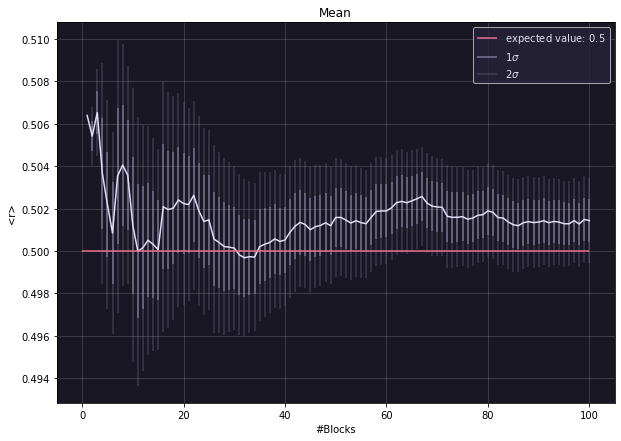

In [48]:
data = np.genfromtxt("out/011-mean_value.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,2]
e=data[:,3]

fig=plt.figure(figsize=(10, 7))
PlotSetup()

plt.hlines(0.5, 0,conf["N_BLOCKS"],color=el3, zorder=5, label="expected value: $0.5$")
Errbar2Sigma(x,y,e)

plt.xlabel('#Blocks')
plt.ylabel('<r>')
plt.title("Mean")
Legend()
plt.show()

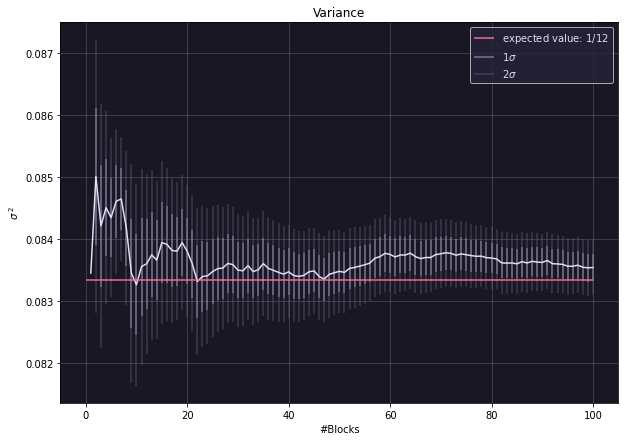

In [49]:
data = np.genfromtxt("out/011-variance.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,2]
e=data[:,3]

fig=plt.figure(figsize=(10, 7))
PlotSetup()

plt.hlines(1/12, 0,conf["N_BLOCKS"],color=el3, zorder=5,label="expected value: $1/12$")
Errbar2Sigma(x,y,e)

plt.xlabel('#Blocks')
plt.ylabel('$\sigma\,^2$')
plt.title("Variance")
Legend()
plt.show()

We can see that the values obtained are compatible with the expected average of $0.5$ and with the expected variance of $1/12$.

###  $\chi^2$ test

We run `N_TESTS` $\chi^2$ tests with `THROWS` throws each. The $[0,1)$ interval has been divided in `N_INTERVALS` subintervals - where:

In [16]:
conf=LoadConf("in/011-chi2-conf.inl")
PrintConf(conf)

N_INTERVALS        100
THROWS             10000
N_TESTS            100


Since we want to test the hypothesis that our numbers are drawn from a uniform distribution, the expectation value is `THROWS/N_INTERVALS`=100

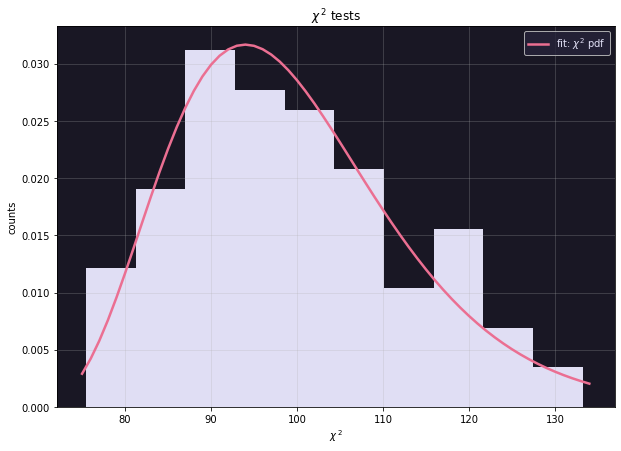

In [31]:
data = np.genfromtxt("out/011-chi2.dat")

fig=plt.figure(figsize=(10, 7))
PlotSetup()

plt.hist(data,color=el1,density=True)

params = chi2.fit(data) 
x = np.arange(75,135)
y = chi2.pdf(x, *params)
plt.plot(x, y, color=el3, linewidth=2.5, label='fit: $\chi^2$ pdf')

plt.xlabel('$\chi\,^2$')
plt.ylabel('counts')
plt.title("$\chi\,^2$ tests")
Legend()
plt.show()

The plot is a normalized histogram representing the distribution of the $\chi^2$ resulting from our tests. Though the number of tests is not enough for a precise fit, we can see that our histogram is well fitted by an actual $\chi^2$ pdf peaked in a neighbourhood of $100$. This means that it's rather unlikely for our numbers not to be generated from a uniform distribution.

## 01.2 - Testing the central limit theorem

### Introductory notes
As said, with a uniform random number generator we can sample other pdfs. An efficent method is the Inversion of the Cumulative Method, which is applicable under quite strong hypothesis:
- the pdf $p$ has to be integrable
- its cumulative $F(x)=\int_{-\infty}^x p(s) ds$ has to be invertible
- we must have an analytic expression for its inverse

If these three requirements are met we have that if $y$ is drawn from a uniform distribution in $[0,1)$ then 
$x=F^{-1}(y)$ is drawn from $p$ (In fact, just the first two hypothesis are *foundamental*. Nevertheless if the third is not fulfilled we won't have an exact sampling when we implement the method). Luckly this is the case for exponential distribution and Cauchy-Lorenz distribution, where we have:
\begin{equation}
    \begin{split}
        p_{\lambda}:[0,+\infty)\to [0,+\infty):x\mapsto \lambda e^{-\lambda x} 
            &\longleftrightarrow x=-\frac{\ln(1-y)}{\lambda}\\
        p_{\mu,\Gamma}:\mathbb{R}\to [0,+\infty):x\mapsto \frac{1}{\pi}\frac{\Gamma}{(x-\mu)^2-\Gamma^2}
            &\longleftrightarrow x=\Gamma\tan\Bigl[\pi\Bigl(y-\frac{1}{2}\Bigr)\Bigr]+\mu\\
    \end{split}
\end{equation}

The procedure is a little different for the Gaussian distribution, whose cumulative is the error function (not known analitically). We can still use the inversion of the cumulative method considerig the product of two Gaussians and working in polar coordinates (box-muller algorithm).

Equipped with these new tools we can, for example, test the central limit theorem (CLT) which states that, if we have
- a set $\{x_i\}$ of indipendent and equally distributed random variables
- with expectation value $\mu$
- and **finite** variance $\sigma^2$

then for the quantity $A_N=\sum_i^N x_i$ in the limit $N\to\infty$ it is true that:
- $\langle A_N \rangle \to \mu$
- $\sigma^2_{A_N}\to \sigma^2/N$
- the pdf of $A_N$, $p_{A_N}\to N(\mu,\sigma^2_{A_N})$ with $N$ the Gaussian 

This is the case for the uniform and the exponential distribution! On the other hand, the Cauchy-Lorenz distribution has infinite variance. A generalization of the theorem states that if a pdf convolution fulfils some properties, that pdf is a limit pdf. This is the case for the lorenzian, which is its own limit function.

According to what we have stated, we can test the CLT in the following way: We make an histogram of a large number of realizations of $A_N=\sum_i^N x_i/N$ and for large $N$ we expect it to converge to the limit distribution - a Gaussian if $x_i$ are generated using the uniform and the exponential distribution, a lorenzian if they are generated from a lorenzian.

### Excercise goal
**Goal:** Extending the pseudo-random number generator introducing sampling from the exponential and the Cauchy-Lorentz distribution (using the method of the inverse cumulative distribution); Testing the central limit theorem (and it's generalized version) throwing a:
- Uniform dice
- Exponential dice ($\lambda=1$)
- Cauchy-Lorentz dice ($\mu=0$, $\Gamma=1$)

and making histograms of a large number of realizations of $A_N$.

**Expectations:** We expect that for large $N$ the histograms of obtained from the uniform and the exponential dices will be well fitted by a gaussian, while the lorentzian dice (having the distribution infinite variance) will be well fitted by a lorentzian. 

### Results
The histograms are made using `T` realizations of $A_N$ - where:

In [10]:
conf=LoadConf("in/012-conf.inl")
PrintConf(conf)

T                  10000


#### Uniform dice
We decided to use the interval $[0,1)$ and to divide it in 100 subintervals. In this way the convergence to the normal distribution is clearer and we can use the knowledge gained in the previous exercise to check if $\mu$ and $\sigma$ are compatible with those expected. Clearly, we are not properly simulating a dice. This is justified by the fact that the term "dice" was already forced to be intended in somehow a broader meaning for the exponential and the lorentzian dices, since their values is taken in an infinite interval.

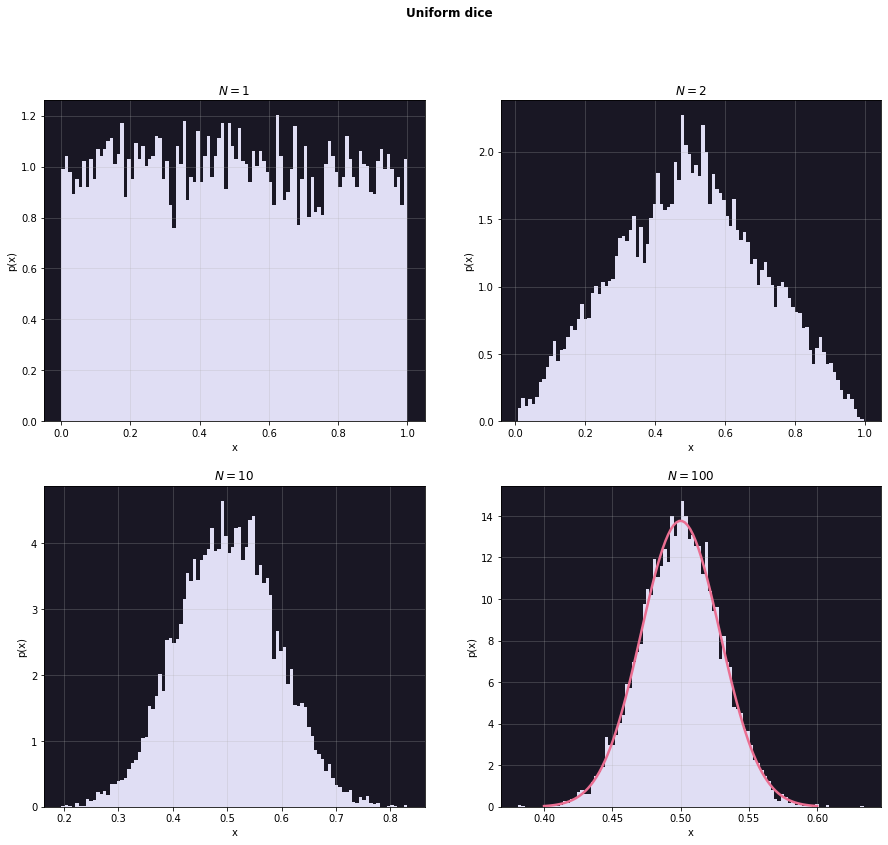

Gaussian with parameters:
μ=0.5000059557000001
σ=0.028981971839868618


In [35]:
xs = np.genfromtxt("out/012-unif.csv", delimiter=",", skip_header=1)

fig=plt.figure(figsize=(15, 13))
MultiplotSetup(fig,2,2)
plt.suptitle('Uniform dice', weight='bold')

#N=1
plt.subplot(221)
plt.hist(xs[:,0],100, density=True, color=el1)
plt.title('$N=1$')
plt.xlabel('x')
plt.ylabel('p(x)')


#N=2
plt.subplot(222)
plt.hist(xs[:,1],100, density=True, color=el1)
plt.title('$N=2$')
plt.xlabel('x')
plt.ylabel('p(x)')

#N=10
plt.subplot(223)
plt.hist(xs[:,2],100, density=True, color=el1)
plt.title('$N=10$')
plt.xlabel('x')
plt.ylabel('p(x)')

#N=100
plt.subplot(224)
plt.hist(xs[:,3],100, density=True, color=el1)

parameter = norm.fit(xs[:,3]) 
x = np.linspace(0.4, 0.6, 100)
y = norm.pdf(x, *parameter)
plt.plot(x, y, color=el3, linewidth=2.5)

plt.title('$N=100$')
plt.xlabel('x')
plt.ylabel('p(x)')



plt.show()
print("Gaussian with parameters:")
print("\u03BC="+str(parameter[0]))
print("\u03C3="+str(parameter[1]))

$\mu\simeq 0.5$ as predicted by the CLT. Moreover for $N=100$ we have $\sqrt{1/12\,\, 1/N}\simeq0.0286$, then also $\sigma$ fulfils our expectations.

#### Exponential dice

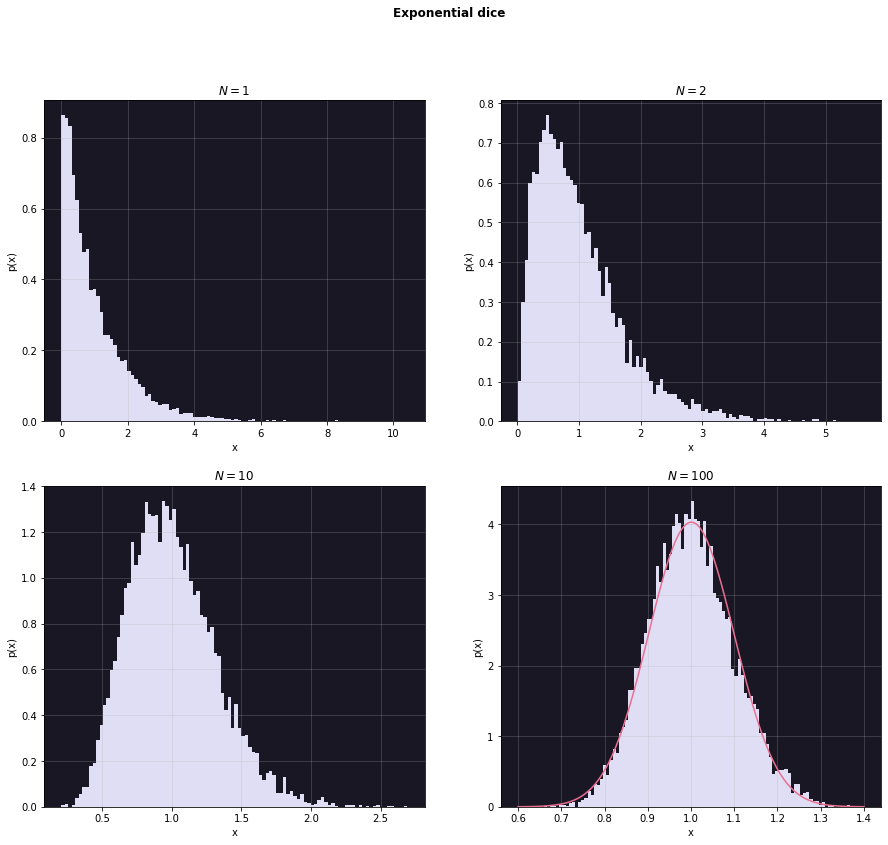

In [36]:
xs = np.genfromtxt("out/012-exp.csv", delimiter=",", skip_header=1)

fig=plt.figure(figsize=(15, 13))
MultiplotSetup(fig,2,2)
plt.suptitle('Exponential dice', weight='bold')

#N=1
plt.subplot(221)
plt.hist(xs[:,0],100, density=True, color=el1)
plt.title('$N=1$')
plt.xlabel('x')
plt.ylabel('p(x)')


#N=2
plt.subplot(222)
plt.hist(xs[:,1],100, density=True, color=el1)
plt.title('$N=2$')
plt.xlabel('x')
plt.ylabel('p(x)')

#N=10
plt.subplot(223)
plt.hist(xs[:,2],100, density=True, color=el1)
plt.title('$N=10$')
plt.xlabel('x')
plt.ylabel('p(x)')

#N=100
plt.subplot(224)
plt.hist(xs[:,3],100, density=True, color=el1)

parameter = norm.fit(xs[:,3]) 
x = np.linspace(0.6, 1.4, 100)
y = norm.pdf(x, *parameter)
plt.plot(x, y, color=el3)

plt.title('$N=100$')
plt.xlabel('x')
plt.ylabel('p(x)')

plt.show()


#### Lorentzian dice

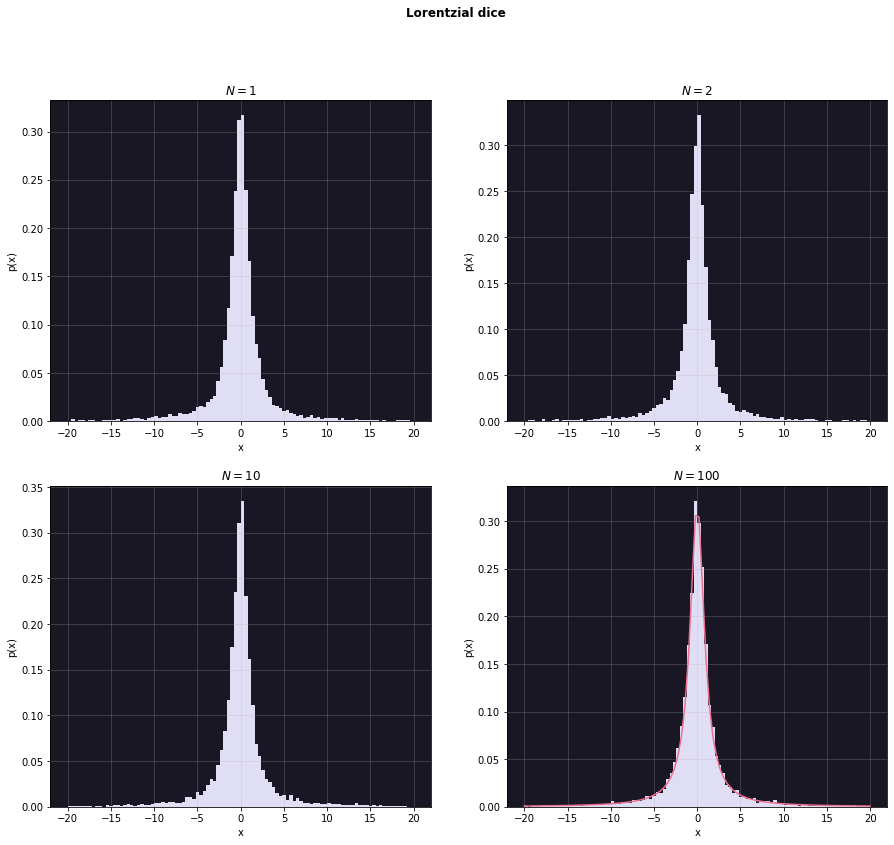

In [37]:
xs = np.genfromtxt("out/012-cauchy.csv", delimiter=",", skip_header=1)
edge=20

fig=plt.figure(figsize=(15, 13))
MultiplotSetup(fig,2,2)
plt.suptitle('Lorentzial dice', weight='bold')

#N=1
plt.subplot(221)
plt.hist(xs[:,0], 100, range=(-edge,edge), density=True, color=el1)
plt.title('$N=1$')
plt.xlabel('x')
plt.ylabel('p(x)')

#N=2
plt.subplot(222)
plt.hist(xs[:,1],100, range=(-edge,edge), density=True, color=el1)
plt.title('$N=2$')
plt.xlabel('x')
plt.ylabel('p(x)')

#N=10
plt.subplot(223)
plt.hist(xs[:,2], 100, range=(-edge,edge), density=True, color=el1)
plt.title('$N=10$')
plt.xlabel('x')
plt.ylabel('p(x)')

#N=100
plt.subplot(224)
plt.hist(xs[:,3], 100, range=(-edge,edge), density=True, color=el1)

parameter = cauchy.fit(xs[:,3]) 
x = np.linspace(-edge, edge, 100)
y = cauchy.pdf(x, *parameter)
plt.plot(x, y, color=el3)

plt.title('$N=100$')
plt.xlabel('x')
plt.ylabel('p(x)')


plt.show()

All histograms confirm our expectation.

## 01.3 - Buffon's experiment
### Introductory notes
Buffon's experiment is the name of a procedure to evaluate $\pi$ using a stochastic method. If we take a flat surface ruled with parallel lines at distance $d$, the probability that a needle of lenght $l<d$ intersects one of those lines is
\begin{equation}
    P=\frac{d\pi}{2l}
\end{equation}
Inverting this formula we can evaluate $\pi$. all we have to do is to throw a bounch of needles onto the flat surface and count how many needles intersect a line. Then we can get an estimate of $P$ by dividing this number for the total number of needles. The more the throws, the better the approximation.

To simulate the experiment we firstly make some observation. We clearly see some symmetries: the problem is equivalent to that of "throwing" a segment of random lenght (the projection of the needle in the direction orthogonal to the lines) onto a 1d lattice of equally spaced points, and the fact that we are only considering the projection means that the meaningful interval for the angle is that of width $\pi/2$; even more, the translational symmetry allow us to focus on a single "cell" of the lattice and , since we don't need to know which part of the needle intersects the line, we can focus only on half-a-cell. Let's call $0$ the lower bound of the cell we are focusing on. We produce a random number $r\sim unif(0,1) \times d/2$ representing the needle middle-point poistion in half the cell. We then uniformly produce an angle $\theta$ representing the inclination of the needle and evaluate the projection $\cos\theta l$. The needle hits a boundary if $rd/2-\cos\theta l/2\leq 0$ that is $rd\leq cos\theta l$. This way we minimized the number of mathematical operations and checks that needs to be done for each throw.

We must notice that a direct sample of the angle needed for the projection would require to know the value of $\pi$. One would be tempted to try to generate the projection randomly and not just the angle, but to implement the inversion of the cumulative we still have to know $\pi$. In order to avoid that we can sample a "directional vector" in the first quadrant of the plane instead of the angle, by generating its coordinate $(x,y)$ in the square $[0,1)\times[0,1)$. Clealrly the more we get near the diagonal of the square the more vectors become available: to generate the vector uniformly we have to impose that $(x,y)$ lies in the circumference of radious 1. 

### Excercise goal
**Goal:** Implement the Buffon's experiment to get an estimation for the value of $\pi$.

**Expectations:**  Well, $\pi$!
 

### Results
We used a grid of lines at distance `GRID_SPACE` and needles of lenght `NEEDLE_LENGHT` - where:

In [3]:
conf=LoadConf("in/013-conf-experiment.inl")
PrintConf(conf)

NEEDLE_LENGHT      1
GRID_SPACE         2


For data blocking we used `N_BLOCKS` blocks with `STEPS_PER_BLOCK` steps each - 
where:

In [6]:
conf=LoadConf("in/013-conf-datablocking.inl")
PrintConf(conf)

N_BLOCKS           100
STEPS_PER_BLOCK    10000


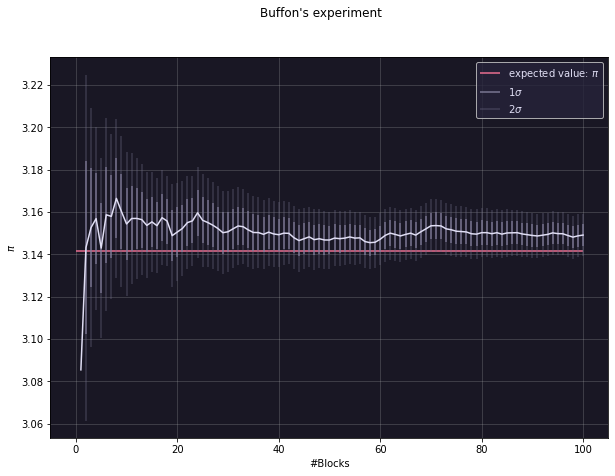

In [50]:
data = np.genfromtxt("out/013-pi_progressive_estimate.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,2]
e=data[:,3]

fig=plt.figure(figsize=(10, 7))
PlotSetup()

plt.suptitle("Buffon's experiment")

plt.hlines(pi, 0, conf["N_BLOCKS"],color=el3, label="expected value: $\pi$")
Errbar2Sigma(x,y,e)

plt.xlabel('#Blocks')
plt.ylabel('$\pi$')
Legend()

plt.show()

We have plotted the progressive averages for the estimated value of $\pi$ in function of the number of blocks and the true value of $\pi$. As we can see, our estimation in compatible with the true value of  $\pi$.